# This script is used for preparation for the operations in Porto. 

In [62]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, GeometryCollection
import h5py
from math import degrees, radians
from numpy import vectorize
import time
from matplotlib.cm import get_cmap

## Set universal WGS module

In [14]:

"""
WGS 84 coordinate system.
North-East-Down reference is employed.

It converts (lat, lon) in degrees to (x, y) in meters given a specific origin.
The selected origin is at Nidarosdomen in Trondheim.

Example:
    >>> wgs = WGS()
    >>> x, y = wgs.latlon2xy(41.065, -8.68281012789546)
    >>> print(x, y)
    >>> 0.0, 0.0
    >>> x, y = 1000, 2000
    >>> lat, lon = wgs.xy2latlon(x, y)
    >>> print(lat, lon)
    >>> 41.17112605658141 -8.59808602737396
"""


class WGS:
    __CIRCUMFERENCE = 40075000  # [m], circumference
    __LATITUDE_ORIGIN = 41.065
    __LONGITUDE_ORIGIN = -8.68281012789546

    @staticmethod
    @vectorize
    def latlon2xy(lat: float, lon: float) -> tuple:
        x = radians((lat - WGS.__LATITUDE_ORIGIN)) / 2 / np.pi * WGS.__CIRCUMFERENCE
        y = radians((lon - WGS.__LONGITUDE_ORIGIN)) / 2 / np.pi * WGS.__CIRCUMFERENCE * np.cos(radians(lat))
        return x, y

    @staticmethod
    @vectorize
    def xy2latlon(x: float, y: float) -> tuple:
        lat = WGS.__LATITUDE_ORIGIN + degrees(x * np.pi * 2.0 / WGS.__CIRCUMFERENCE)
        lon = WGS.__LONGITUDE_ORIGIN + degrees(y * np.pi * 2.0 / (WGS.__CIRCUMFERENCE * np.cos(radians(lat))))
        return lat, lon

    @staticmethod
    def set_origin(lat: float, lon: float) -> None:
        """ Update the origin for the coordinate system. """
        WGS.__LATITUDE_ORIGIN = lat
        WGS.__LONGITUDE_ORIGIN = lon

    @staticmethod
    def get_origin() -> tuple:
        """ Return origin lat, lon in degrees. """
        return WGS.__LATITUDE_ORIGIN, WGS.__LONGITUDE_ORIGIN

    @staticmethod
    def get_circumference() -> float:
        """ Return the circumference for the earth in meters. """
        return WGS.__CIRCUMFERENCE


if __name__ == "__main__":
    wgs = WGS()
    x, y = wgs.latlon2xy(41.065, -8.68281012789546)
    print(x, y)
    x, y = 1000, 2000
    lat, lon = wgs.xy2latlon(x, y)
    print(lat, lon)


0.0 0.0
41.073983156581406 -8.658977758622061


# OP2: Long-horizon path planning in Douro river mouth.

## Stage I: get operational area and origin. 

41.04068871469593 -8.813846858228182
[[14255.15453767  5709.75943741]
 [ 6655.93266267  6090.08594322]
 [ 6569.54877378  -217.02662071]
 [    0.             0.        ]
 [ 2463.42533384 11085.316791  ]
 [ 8832.34529913 11091.94966078]
 [11678.38384112 10215.62113641]
 [14255.15453767  5709.75943741]]


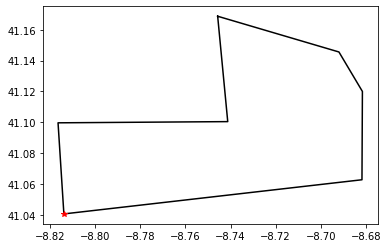

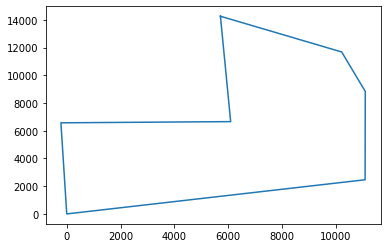

In [23]:
def vectorise(v):
    return np.array(v).reshape(-1, 1)

# s1: load allowed region
path = "OperationArea.csv"
plg_allowed = pd.read_csv(path).to_numpy()

# s2: load delft3d data area
plg_delft3d = np.array([[41.0382, -8.8287],
                        [41.0665, -8.6598],
                        [41.2265, -8.7249],
                        [41.2221, -8.8574]])

# s3: get intersected operational area
ins = []
ins.append(Polygon(plg_allowed).intersection(Polygon(plg_delft3d)))
opr = GeometryCollection(ins)
opa = opr.geoms
lat_op = vectorise(opa[0].exterior.xy[0])
lon_op = vectorise(opa[0].exterior.xy[1])
plg_op = np.hstack((lat_op, lon_op))

# plt.plot(plg_allowed[:, 1], plg_allowed[:, 0], 'r-.')
# plt.plot(plg_allowed[-3, 1], plg_allowed[-3, 0], 'k.')
# plt.plot(plg_delft3d[:, 1], plg_delft3d[:, 0], 'b-.')
plt.plot(plg_op[:, 1], plg_op[:, 0], 'k-')
lat_origin, lon_origin = plg_op[3, :]
plt.plot(lon_origin, lat_origin, 'r*')

# s5: get origin in lat, lon
# print(lat_origin, lon_origin)

# s6: convert lat lon of polygon to xy and then save to file to be used. 
wg = WGS()
wg.set_origin(lat_origin, lon_origin)
x, y = wg.latlon2xy(plg_op[:, 0], plg_op[:, 1])
plg_op_xy = np.stack((x, y), axis=1)
df = pd.DataFrame(plg_op, columns=['lat', 'lon'])
df.to_csv("OPA_GOOGLE.csv", index=False)
print(plg_op_xy)
plt.figure()
plt.plot(y, x)


## TODO: filter data from the surface of Delft3D for that polygon, then set up variogram and coefficients and then determine the A* or PRM or RRT* and finish the system. Do Simulation and HITL. Then launch the mission. 

## Data interpolation on grid with wind directions and tide filtering. Now this part is moved to GPU03 remote server. 


In [ ]:
# path = "raw/Nov2016_sal_1.mat"

# t1 = time.time()
# data = h5py.File(path, 'r')
# t2 = time.time()
# print("Time consumed: ", t2 - t1)

# data = data.get('data')
# lon = np.array(data.get("X")).squeeze()
# lat = np.array(data.get("Y")).squeeze()
# depth = np.array(data.get("Z"))
# Time = np.array(data.get('Time'))
# timestamp = (Time - 719529) * 24 * 3600  # 719529 is how many days have passed from Jan1 0,
# # to Jan1 1970. Since 1970Jan1, is used as the starting index for datetime
# sal_data = np.array(data["Val"])



## Variogram analysis

## MOHID data

In [96]:
depth = []
salinity = []

for i in range(1, 26):
    string_z = "Vertical_{:05d}".format(i)
    string_sal = "salinity_{:05d}".format(i)
    depth.append(np.mean(np.array(grid.get("VerticalZ").get(string_z)), axis = 0))
    salinity.append(np.mean(np.array(data.get("Results").get("salinity").get(string_sal)), axis = 0))

depth = np.array(depth)
salinity = np.array(salinity)
t2 = time.time()
print("Data is loaded correctly, time consumed: ", t2 - t1)

Data is loaded correctly, time consumed:  8.971606016159058


In [88]:
# z = grid.get("VerticalZ").get("Vertical_00005")
# sal = data.get("Results").get("salinity").get("salinity_00001")
# sal.shape
# plt.scatter(lon, lat, c=z[0, :, :], cmap=get_cmap("BrBG", 10), vmin=10, vmax=35)
# plt.colorbar()
sal.shape

(1, 244, 115)

<KeysViewHDF5 ['salinity_00001', 'salinity_00002', 'salinity_00003', 'salinity_00004', 'salinity_00005', 'salinity_00006', 'salinity_00007', 'salinity_00008', 'salinity_00009', 'salinity_00010', 'salinity_00011', 'salinity_00012', 'salinity_00013', 'salinity_00014', 'salinity_00015', 'salinity_00016', 'salinity_00017', 'salinity_00018', 'salinity_00019', 'salinity_00020', 'salinity_00021', 'salinity_00022', 'salinity_00023', 'salinity_00024', 'salinity_00025']>

## Path planner analysis